In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

2022-11-30 12:13:02.680638: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/d/miniconda3/envs/tflow/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Entrenar

In [11]:
import pathlib
import warnings 
warnings.filterwarnings('ignore') # Supress warnings

IMG_SIZE = 224
NUM_CLASSES = 10

# Path con subdirectorios para cada label (0's, 1's, ...)
data_dir = pathlib.Path('../data/MNIST/')

classnames = dict((f'{i}', i) for i in range(NUM_CLASSES))

In [22]:
img_height,img_width=IMG_SIZE,IMG_SIZE
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 64122 files belonging to 10 classes.
Using 51298 files for training.
Found 64122 files belonging to 10 classes.
Using 12824 files for validation.


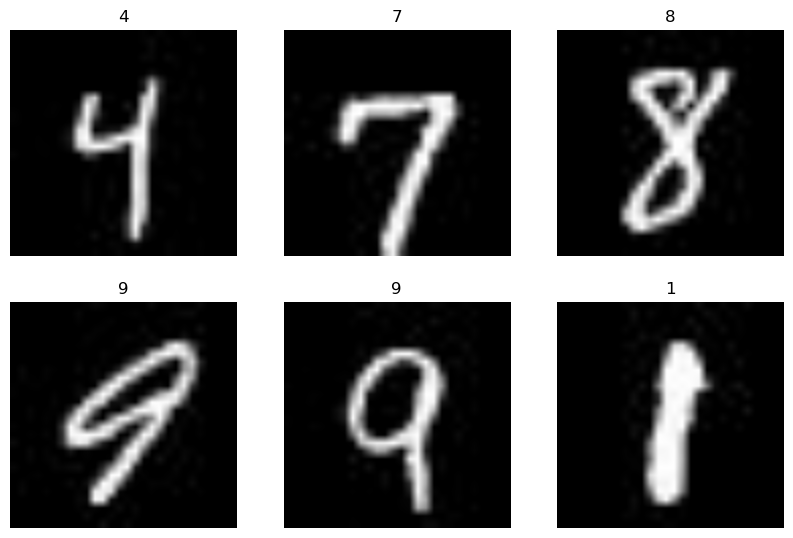

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    labels = labels.numpy()
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
#         label = np.argmax(labels[i], axis=-1) # convert from one-hot back to label
        plt.title(classnames[str(labels[i])])
        plt.axis("off")

In [25]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                    input_shape=(IMG_SIZE,IMG_SIZE,3),
                    pooling='avg',
                    classes=NUM_CLASSES,
                    weights='imagenet'
                    )
for layer in pretrained_model.layers:
    layer.trainable=False

resnet_model.add(pretrained_model)

# add FC layer and output layer
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(NUM_CLASSES, activation='softmax'))

In [26]:
L_R = 0.001
N_EPOCHS = 10
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 24,641,930
Trainable params: 1,054,218
Non-trainable params: 23,587,712
_________________________________________________________________


In [27]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [28]:
resnet_model.compile(optimizer=Adam(lr=L_R),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=N_EPOCHS)

Epoch 1/10
1604/1604 [==============================] - 914s 568ms/step - loss: 0.3444 - accuracy: 0.8959 - val_loss: 0.0810 - val_accuracy: 0.9746
Epoch 2/10
1604/1604 [==============================] - 602s 375ms/step - loss: 0.1009 - accuracy: 0.9685 - val_loss: 0.1628 - val_accuracy: 0.9474
Epoch 3/10
1604/1604 [==============================] - 785s 489ms/step - loss: 0.0782 - accuracy: 0.9742 - val_loss: 0.1226 - val_accuracy: 0.9622
Epoch 4/10
1604/1604 [==============================] - 921s 574ms/step - loss: 0.0684 - accuracy: 0.9773 - val_loss: 0.0747 - val_accuracy: 0.9765
Epoch 5/10
1604/1604 [==============================] - 907s 565ms/step - loss: 0.0560 - accuracy: 0.9815 - val_loss: 0.0823 - val_accuracy: 0.9740
Epoch 6/10
1604/1604 [==============================] - 904s 563ms/step - loss: 0.0436 - accuracy: 0.9866 - val_loss: 0.0835 - val_accuracy: 0.9747
Epoch 7/10
1604/1604 [==============================] - 905s 564ms/step - loss: 0.0390 - accuracy: 0.9872 - val_

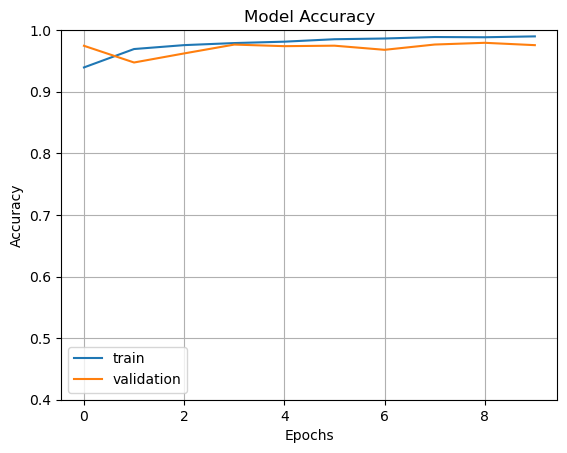

In [29]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [30]:
resnet_model.save_weights('./resnetUTK')

# Predecir

In [34]:
resnet_model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                    input_shape=(IMG_SIZE,IMG_SIZE,3),
                    pooling='avg',
                    classes=NUM_CLASSES,
                    weights='imagenet'
                    )
for layer in pretrained_model.layers:
    layer.trainable=False
resnet_model.add(pretrained_model)
# add FC layer and output layer
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(NUM_CLASSES, activation='softmax'))
#load weights
resnet_model.load_weights('./resnetUTK')

In [45]:
import cv2
image=cv2.imread('../data/MNIST/9/9_0.jpg')
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)

In [46]:
pred=resnet_model.predict(image)
output_class=classnames[str(np.argmax(pred))]
print("The predicted class is", output_class)

The predicted class is 9
